In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numba import njit

In [153]:
from scipy.stats import truncnorm

MIN_OBS = 100
MAX_OBS = 500

def truncnorm_better(loc=0, scale=1, low=-np.inf, high=np.inf, size=1):
    return truncnorm.rvs(
        (low - loc) / scale, (high - loc) / scale, loc=loc, scale=scale, size=size
    )

In [178]:
def prior_a(batch_size):
    drift = truncnorm_better(0, 2.5, low=0.0, high=np.inf, size=batch_size)
    a0 = truncnorm_better(2, 2, low=0.25, high=np.inf, size=batch_size)
    lamda = truncnorm_better(1, 1.5, low=0.0, high=np.inf, size=batch_size)
    tau = truncnorm_better(0, 0.75, low=0.0, high=np.inf, size=batch_size)
    sigma_z = truncnorm_better(0.1, 0.3, low=0.001, high=np.inf, size=batch_size)
    return np.c_[drift, a0, lamda, tau, sigma_z]

def prior_b(batch_size):
    drift = np.random.uniform(0, 3, size=batch_size)
    a0 = np.random.uniform(1.5, 4, size=batch_size)
    lamda = np.random.uniform(0.1, 2, size=batch_size)
    tau = np.random.uniform(0.05, 1, size=batch_size)
    sigma_z = np.random.uniform(0.05, 0.5, size=batch_size)
    return np.c_[drift, a0, lamda, tau, sigma_z]

In [179]:
prior_a_draws = prior_a(100000)
prior_b_draws = prior_b(100000)
prior_a_draws.shape

(100000, 5)

In [183]:
prior_a_draws.std(axis=0).round(1)

array([1.5, 1.5, 1.1, 0.5, 0.2])

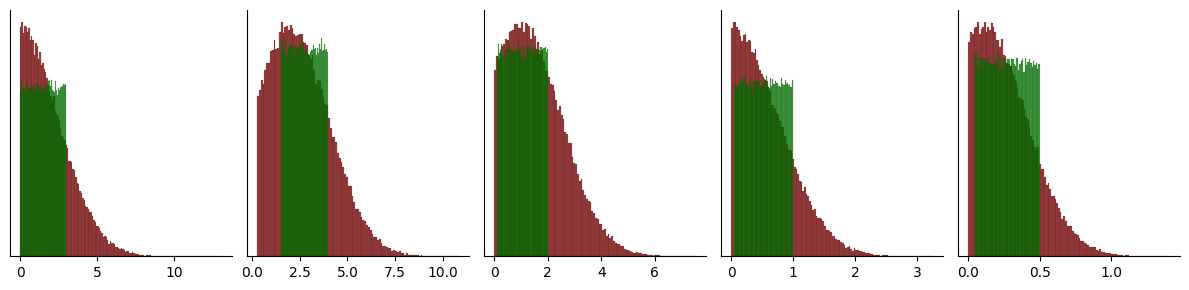

In [180]:
f, axarr = plt.subplots(1, 5, figsize=(12, 3))
for i, ax in enumerate(axarr.flat):
    sns.histplot(prior_a_draws[:, i], color="maroon", alpha=0.75, ax=ax)
    sns.histplot(prior_b_draws[:, i], color="green", alpha=0.75, ax=ax)
    ax.set_ylabel("")
    ax.set_yticks([])
sns.despine()
f.tight_layout()

In [110]:
@njit
def sample_cdm_no_constraint_trial(theta, type, dt=0.001, s=1.0, max_iter=1e5):
    mu1, mu2, a0, lamda, tau = theta
    mu = np.array([mu1, mu2])
    n_iter = 0
    x = np.zeros(2)
    c = np.sqrt(dt) * s
    t = np.arange(0, max_iter * dt, dt)
    if type == "hyperbolic":
        threshold = a0 / (1 + lamda * t)
    else:
        threshold = a0 * np.exp(-lamda * t)

    while np.linalg.norm(x, 2) < threshold[n_iter] and n_iter < max_iter:
        x += mu*dt + c * np.random.randn(2)
        n_iter += 1
    rt = n_iter * dt + tau
    resp = np.arctan2(x[1], x[0])
    return rt, resp

In [151]:
theta = sample_cdm_no_constraint_prior(1)
x = sample_cdm_no_constraint_trial(theta[0], type="exponential")
x

(1.3739899288829516, -2.402931283384423)